In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd

# Load detector and predictor
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat")

# Directories
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal5"
scale_factor = 12

os.makedirs(root_output_dir, exist_ok=True)

emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]
all_landmarks_data = []

# --------- NEW FUNCTION TO EXPAND BOUNDING BOX ---------
def expand_rect(rect, padding, image_shape):
    x1 = max(0, rect.left() - padding)
    y1 = max(0, rect.top() - padding)
    x2 = min(image_shape[1], rect.right() + padding)
    y2 = min(image_shape[0], rect.bottom() + padding)
    return dlib.rectangle(x1, y1, x2, y2)

# --------- MAIN PROCESSING LOOP ---------
print("Starting facial landmark detection...")

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")
    
    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)
    
    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"Warning: Could not read image {image_path}. Skipping.")
                continue
                
            print(f"  Processing file: {filename}")

            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)

            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                padding = 40  # ← KEY FIX for wide mouth
                expanded_face = expand_rect(face, padding, gray.shape)

                landmarks = predictor(gray, expanded_face)

                # Store to CSV
                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                # Prepare image with photo and landmarks
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)

                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1

                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    offset_x, offset_y = -6, 10

                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x = -20
                        offset_y = 6
                    elif n == 50:
                        offset_x = 0
                        offset_y = -8
                    elif n == 65:
                        offset_x = -14
                        offset_y = 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10
                    
                    # WITH photo
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)
                    
                    # WITHOUT photo
                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                # Save outputs
                out_path_with = os.path.join(output_with_photo_path, filename)
                out_path_without = os.path.join(output_without_photo_path, filename)
                cv2.imwrite(out_path_with, drawn_image_with_photo)
                cv2.imwrite(out_path_without, drawn_image_without_photo)
            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nAll emotion folders and photos processed successfully!")

# Save landmark CSV
if all_landmarks_data:
    df = pd.DataFrame(all_landmarks_data)
    csv_output_path = os.path.join(root_output_dir, "facial_landmarks_data.csv")
    df.to_csv(csv_output_path, index=False)
    print(f"All facial landmark coordinates saved to: {csv_output_path}")
else:
    print("No facial landmark data collected.")


Starting facial landmark detection...

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing file: S029_001_00000017.png
  Processing file: S029_001_00000018.png
  Processing file: S029_001_00000019.png
  Processing file: S032_003_00000015.png
  Processing file: S032_003_00

In [1]:
import cv2
import dlib
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# --- Dlib model setup ---
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat/shape_predictor_68_face_landmarks.dat")

# --- Project Paths ---
root_input_dir = "archive_3"
root_output_dir = "processed_faces_newFinal5"
scale_factor = 12
emotion_folders = ["anger", "contempt", "disgust", "happy", "sadness", "fear", "surprise"]

os.makedirs(root_output_dir, exist_ok=True)

# --- Landmark groups for each region ---
REGIONS = {
    'left_eyebrow': list(range(17, 22)),
    'right_eyebrow': list(range(22, 27)),
    'left_eye': list(range(36, 42)),
    'right_eye': list(range(42, 48)),
    'nose': list(range(27, 36)),
    'lips': list(range(48, 68))
}

# --- Storage ---
all_landmarks_data = []
va_dataset = []

# --- Helper functions ---
def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def get_valence_arousal(region_points):
    center = np.mean(region_points, axis=0)
    distances = [euclidean(center, pt) for pt in region_points]
    avg_dist = np.mean(distances)
    valence = np.std(distances)
    arousal = avg_dist
    return valence, arousal

print("Starting landmark detection and 2D valence-arousal vector computation...")

for emotion in emotion_folders:
    input_emotion_path = os.path.join(root_input_dir, emotion)
    output_with_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_with_photo")
    output_without_photo_path = os.path.join(root_output_dir, emotion, f"{emotion}_without_photo")

    os.makedirs(output_with_photo_path, exist_ok=True)
    os.makedirs(output_without_photo_path, exist_ok=True)

    print(f"\nProcessing emotion: {emotion}...")

    for filename in os.listdir(input_emotion_path):
        if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".tiff")):
            image_path = os.path.join(input_emotion_path, filename)
            image = cv2.imread(image_path)

            if image is None:
                print(f"  Warning: Could not read image {image_path}. Skipping.")
                continue

            print(f"  Processing file: {filename}")
            upscaled_image = cv2.resize(image, (0, 0), fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
            gray = cv2.cvtColor(upscaled_image, cv2.COLOR_BGR2GRAY)
            faces = detector(gray)

            if len(faces) > 0:
                face = faces[0]
                landmarks = predictor(gray, face)

                # Save 68 landmarks for CSV
                landmark_row = {'emotion': emotion, 'filename': filename}
                for n in range(68):
                    x = landmarks.part(n).x
                    y = landmarks.part(n).y
                    landmark_row[f'landmark_{n}_x'] = x
                    landmark_row[f'landmark_{n}_y'] = y
                all_landmarks_data.append(landmark_row)

                # Build the valence-arousal vector
                landmark_coords = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in range(68)])
                va_row = {'filename': filename, 'emotion': emotion}

                for region_name, indices in REGIONS.items():
                    region_pts = landmark_coords[indices]
                    valence, arousal = get_valence_arousal(region_pts)
                    va_row[f'{region_name}_valence'] = valence
                    va_row[f'{region_name}_arousal'] = arousal

                va_dataset.append(va_row)

                # ---------- Drawing Code (Optional for Visualization) ----------
                drawn_image_with_photo = upscaled_image.copy()
                drawn_image_without_photo = np.zeros(upscaled_image.shape, dtype=np.uint8)
                nose_x = landmarks.part(30).x
                nose_y = landmarks.part(30).y
                img_h, img_w = drawn_image_with_photo.shape[:2]

                # Draw quadrant lines on photo image
                cv2.line(drawn_image_with_photo, (nose_x, 0), (nose_x, img_h), (0, 255, 0), 1)
                cv2.line(drawn_image_with_photo, (0, nose_y), (img_w, nose_y), (0, 255, 0), 1)

                drawn_index = 1
                seen = set()

                for n in range(68):
                    x, y = landmark_coords[n]
                    if (x, y) in seen:
                        continue
                    seen.add((x, y))

                    circle_color = (0, 0, 255)
                    circle_radius = 2
                    fill_type = -1
                    text_font = cv2.FONT_HERSHEY_SIMPLEX
                    text_scale = 0.35
                    offset_x, offset_y = -6, 10

                    # Offset tuning
                    if n in [37, 38, 39, 43, 44, 45]:
                        offset_y = -10
                    elif n == 49:
                        offset_x, offset_y = -20, 6
                    elif n == 50:
                        offset_x, offset_y = 0, -8
                    elif n == 65:
                        offset_x, offset_y = -14, 10
                    elif 48 <= n <= 54:
                        offset_y = -8
                    elif 55 <= n <= 59:
                        offset_y = 10
                    elif 60 <= n <= 64:
                        offset_y = -8
                    elif 65 <= n <= 67:
                        offset_y = 10

                    # Draw landmarks
                    cv2.circle(drawn_image_with_photo, (x, y), circle_radius, circle_color, fill_type)
                    cv2.putText(drawn_image_with_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (0, 0, 0), 1, cv2.LINE_AA)

                    cv2.circle(drawn_image_without_photo, (x, y), circle_radius, (255, 255, 255), fill_type)
                    cv2.putText(drawn_image_without_photo, str(drawn_index), (x + offset_x, y + offset_y),
                                text_font, text_scale, (255, 255, 255), 1, cv2.LINE_AA)

                    drawn_index += 1

                # Save images
                cv2.imwrite(os.path.join(output_with_photo_path, filename), drawn_image_with_photo)
                cv2.imwrite(os.path.join(output_without_photo_path, filename), drawn_image_without_photo)

            else:
                print(f"  No face detected in {filename} from {emotion} folder.")

print("\nAll images processed!")

# --- Save raw outputs ---
if all_landmarks_data:
    pd.DataFrame(all_landmarks_data).to_csv(
        os.path.join(root_output_dir, "facial_landmarks_data.csv"), index=False
    )
    print("✅ Landmark coordinates saved.")

if va_dataset:
    va_df = pd.DataFrame(va_dataset)
    va_df.to_csv(os.path.join(root_output_dir, "valence_arousal_vectors.csv"), index=False)
    print("✅ Raw valence-arousal 2D vectors saved.")

    # --- Normalize valence/arousal columns ---
    va_columns = [col for col in va_df.columns if '_valence' in col or '_arousal' in col]
    scaler = MinMaxScaler(feature_range=(-1, 1))
    va_df[va_columns] = scaler.fit_transform(va_df[va_columns])

    # Save normalized version
    va_df.to_csv(os.path.join(root_output_dir, "valence_arousal_vectors_normalized.csv"), index=False)
    print("✅ Normalized valence-arousal vectors saved.")

else:
    print("⚠️ No valence-arousal data collected.")


Starting landmark detection and 2D valence-arousal vector computation...

Processing emotion: anger...
  Processing file: S010_004_00000017.png
  Processing file: S010_004_00000018.png
  Processing file: S010_004_00000019.png
  Processing file: S011_004_00000019.png
  Processing file: S011_004_00000020.png
  Processing file: S011_004_00000021.png
  Processing file: S014_003_00000028.png
  Processing file: S014_003_00000029.png
  Processing file: S014_003_00000030.png
  Processing file: S022_005_00000030.png
  Processing file: S022_005_00000031.png
  Processing file: S022_005_00000032.png
  Processing file: S026_003_00000013.png
  Processing file: S026_003_00000014.png
  Processing file: S026_003_00000015.png
  Processing file: S028_001_00000022.png
  Processing file: S028_001_00000023.png
  Processing file: S028_001_00000024.png
  Processing file: S029_001_00000017.png
  Processing file: S029_001_00000018.png
  Processing file: S029_001_00000019.png
  Processing file: S032_003_00000015


Classification Report:
              precision    recall  f1-score   support

       anger       0.80      0.89      0.84        27
    contempt       1.00      0.55      0.71        11
     disgust       0.89      0.89      0.89        35
        fear       1.00      0.87      0.93        15
       happy       0.89      1.00      0.94        41
     sadness       0.81      0.76      0.79        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.91       196
   macro avg       0.91      0.85      0.87       196
weighted avg       0.91      0.91      0.91       196

Accuracy: 0.91


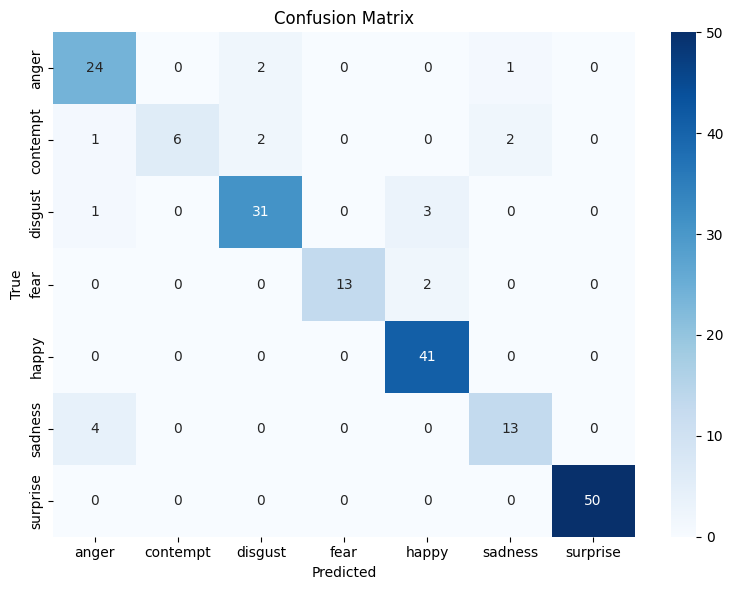

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Load Normalized Feature Data ---
data_path = "processed_faces_newFinal5/valence_arousal_vectors_normalized.csv"
df = pd.read_csv(data_path)

# --- Step 2: Encode Labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Step 3: Prepare Features and Target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]  # 12 features
y = df['emotion_encoded']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Step 4: Train Classifier ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Evaluate Model ---
y_pred = model.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")

# --- Optional: Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



✅ Training Accuracy: 100.00%
✅ Testing Accuracy:  90.82%

Classification Report:
              precision    recall  f1-score   support

       anger       0.80      0.89      0.84        27
    contempt       1.00      0.55      0.71        11
     disgust       0.89      0.89      0.89        35
        fear       1.00      0.87      0.93        15
       happy       0.89      1.00      0.94        41
     sadness       0.81      0.76      0.79        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.91       196
   macro avg       0.91      0.85      0.87       196
weighted avg       0.91      0.91      0.91       196



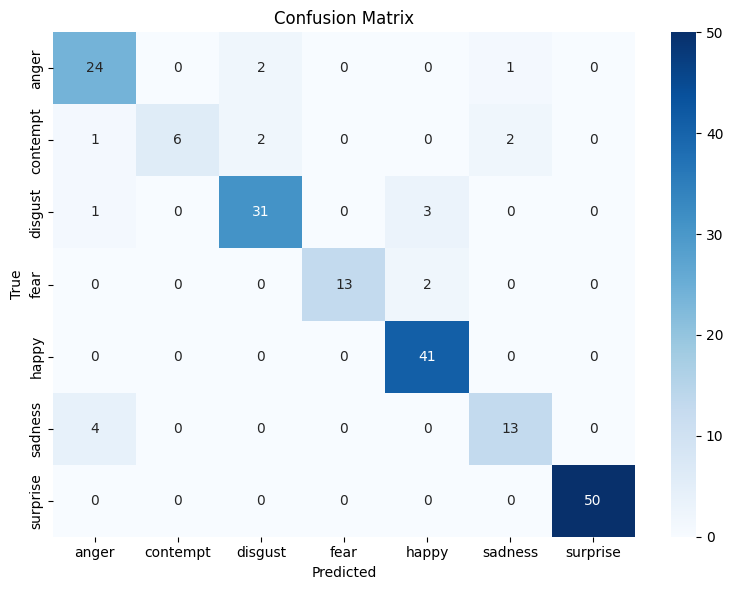

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Load the normalized valence-arousal feature data ---
data_path = "processed_faces_newFinal5/valence_arousal_vectors_normalized.csv"
df = pd.read_csv(data_path)

# --- Step 2: Encode the emotion labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Step 3: Select Features (X) and Target (y) ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]  # 12 features
y = df['emotion_encoded']

# --- Step 4: Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Step 5: Train a Random Forest Classifier ---
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 6: Evaluate Model on Test Set ---
y_pred = model.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)

# Training Accuracy
train_preds = model.predict(X_train)
train_acc = accuracy_score(y_train, train_preds)

print(f"\n✅ Training Accuracy: {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy:  {acc * 100:.2f}%")




# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



✅ Training Accuracy (SVM): 90.69%
✅ Testing Accuracy  (SVM): 86.73%

Classification Report (SVM):
              precision    recall  f1-score   support

       anger       0.68      0.78      0.72        27
    contempt       0.88      0.64      0.74        11
     disgust       0.85      0.94      0.89        35
        fear       0.85      0.73      0.79        15
       happy       0.95      0.95      0.95        41
     sadness       0.71      0.59      0.65        17
    surprise       0.98      0.98      0.98        50

    accuracy                           0.87       196
   macro avg       0.84      0.80      0.82       196
weighted avg       0.87      0.87      0.87       196



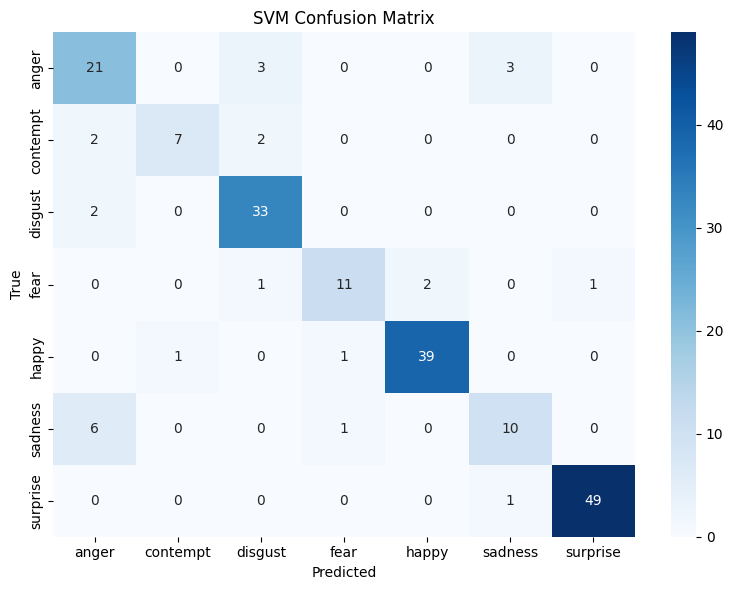

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load normalized valence-arousal vectors ---
data_path = "processed_faces_newFinal5/valence_arousal_vectors_normalized.csv"
df = pd.read_csv(data_path)

# --- Encode emotion labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Features and target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]  # 12D features
y = df['emotion_encoded']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Train SVM with RBF kernel ---
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# --- Evaluate ---
y_train_pred = svm_model.predict(X_train)
y_test_pred = svm_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy (SVM): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (SVM): {test_acc * 100:.2f}%")


# --- Classification Report ---
print("\nClassification Report (SVM):")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Performing Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

✅ Training Accuracy (Tuned SVM): 100.00%
✅ Testing Accuracy  (Tuned SVM): 96.94%

Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93        27
    contempt       1.00      1.00      1.00        11
     disgust       0.97      0.97      0.97        35
        fear       0.88      1.00      0.94        15
       happy       1.00      1.00      1.00        41
     sadness       0.94      0.88      0.91        17
    surprise       1.00      0.98      0.99        50

    accuracy                           0.97       196
   macro avg       0.96      0.97      0.96       196
weighted avg       0.97      0.97      0.97       196



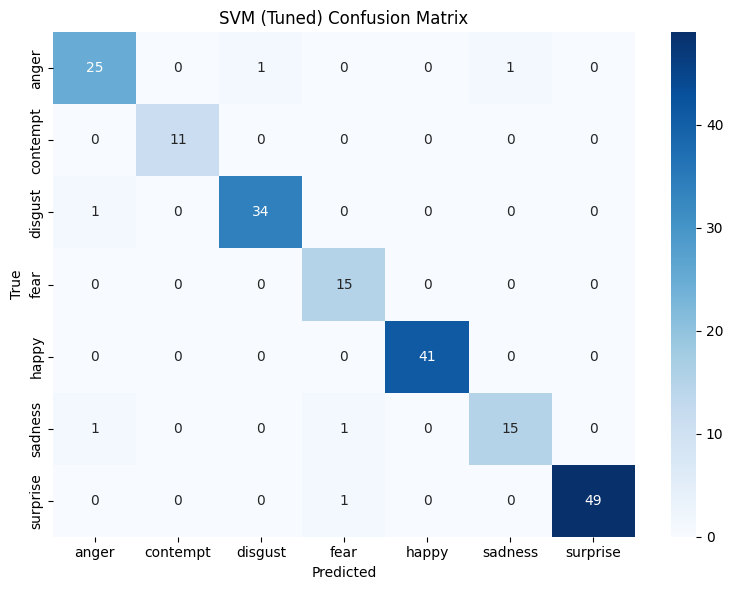

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load normalized valence-arousal data ---
df = pd.read_csv("processed_faces_newFinal5/valence_arousal_vectors_normalized.csv")

# --- Encode emotions ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Features & target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]
y = df['emotion_encoded']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Grid Search for best SVM parameters ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

print("Performing Grid Search...")
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

# --- Best model from grid search ---
best_svm = grid.best_estimator_
print(f"\nBest Parameters: {grid.best_params_}")

# --- Evaluate model ---
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy (Tuned SVM): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVM): {test_acc * 100:.2f}%")


# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Performing Grid Search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters: {'C': 100, 'gamma': 1, 'kernel': 'rbf'}

✅ Training Accuracy (Tuned SVM): 100.00%
✅ Testing Accuracy  (Tuned SVM): 96.94%

Classification Report:
              precision    recall  f1-score   support

       anger       0.93      0.93      0.93        27
    contempt       1.00      1.00      1.00        11
     disgust       0.97      0.97      0.97        35
        fear       0.88      1.00      0.94        15
       happy       1.00      1.00      1.00        41
     sadness       0.94      0.88      0.91        17
    surprise       1.00      0.98      0.99        50

    accuracy                           0.97       196
   macro avg       0.96      0.97      0.96       196
weighted avg       0.97      0.97      0.97       196



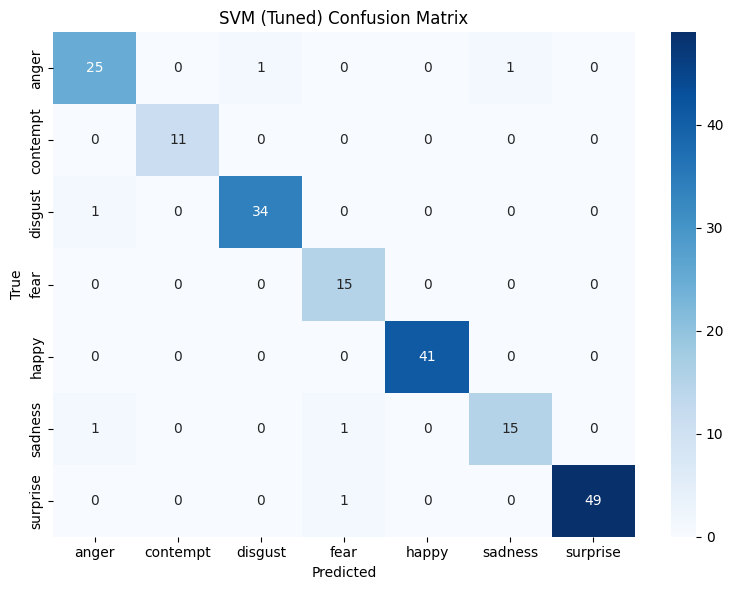

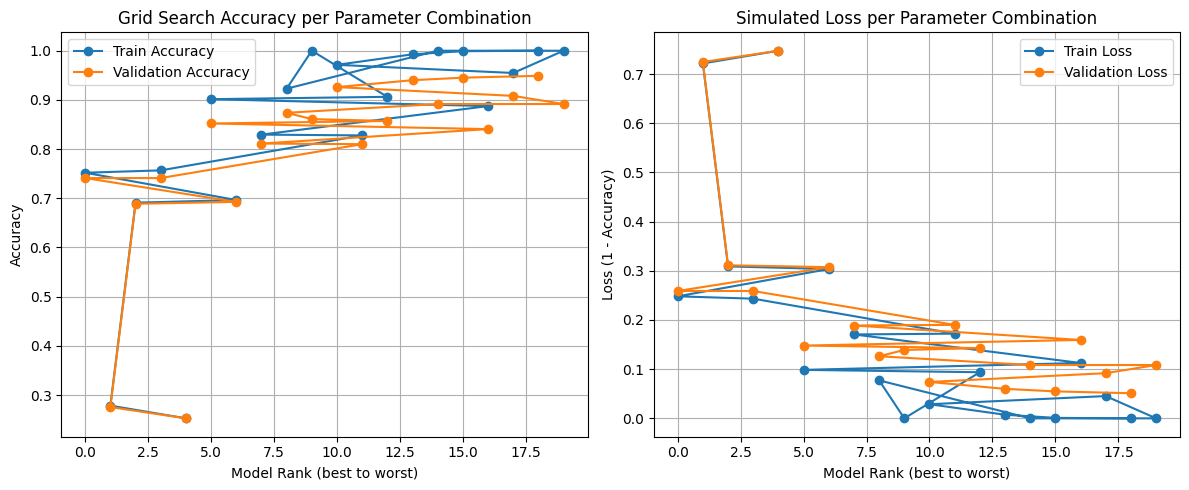

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Load normalized valence-arousal data ---
df = pd.read_csv("processed_faces_newFinal5/valence_arousal_vectors_normalized.csv")

# --- Encode emotions ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Features & target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]
y = df['emotion_encoded']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Grid Search for best SVM parameters ---
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1, 10],
    'kernel': ['rbf']
}

print("Performing Grid Search...")
grid = GridSearchCV(SVC(probability=True), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1, return_train_score=True)
grid.fit(X_train, y_train)

# --- Best model from grid search ---
best_svm = grid.best_estimator_
print(f"\nBest Parameters: {grid.best_params_}")

# --- Evaluate model ---
y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy (Tuned SVM): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Tuned SVM): {test_acc * 100:.2f}%")

# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("SVM (Tuned) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# --- Accuracy and Loss Plot ---
results = pd.DataFrame(grid.cv_results_)

# Sort results by rank to simulate training progression
sorted_results = results.sort_values(by="rank_test_score")

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(sorted_results['mean_train_score'], label='Train Accuracy', marker='o')
plt.plot(sorted_results['mean_test_score'], label='Validation Accuracy', marker='o')
plt.title("Grid Search Accuracy per Parameter Combination")
plt.xlabel("Model Rank (best to worst)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Simulated loss = 1 - accuracy
plt.subplot(1, 2, 2)
plt.plot(1 - sorted_results['mean_train_score'], label='Train Loss', marker='o')
plt.plot(1 - sorted_results['mean_test_score'], label='Validation Loss', marker='o')
plt.title("Simulated Loss per Parameter Combination")
plt.xlabel("Model Rank (best to worst)")
plt.ylabel("Loss (1 - Accuracy)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



✅ Training Accuracy (Logistic Regression): 84.44%
✅ Testing Accuracy  (Logistic Regression): 81.63%

Classification Report:
              precision    recall  f1-score   support

       anger       0.61      0.74      0.67        27
    contempt       0.43      0.27      0.33        11
     disgust       0.82      0.94      0.88        35
        fear       0.83      0.67      0.74        15
       happy       0.91      0.98      0.94        41
     sadness       0.50      0.29      0.37        17
    surprise       0.98      0.98      0.98        50

    accuracy                           0.82       196
   macro avg       0.73      0.70      0.70       196
weighted avg       0.80      0.82      0.80       196



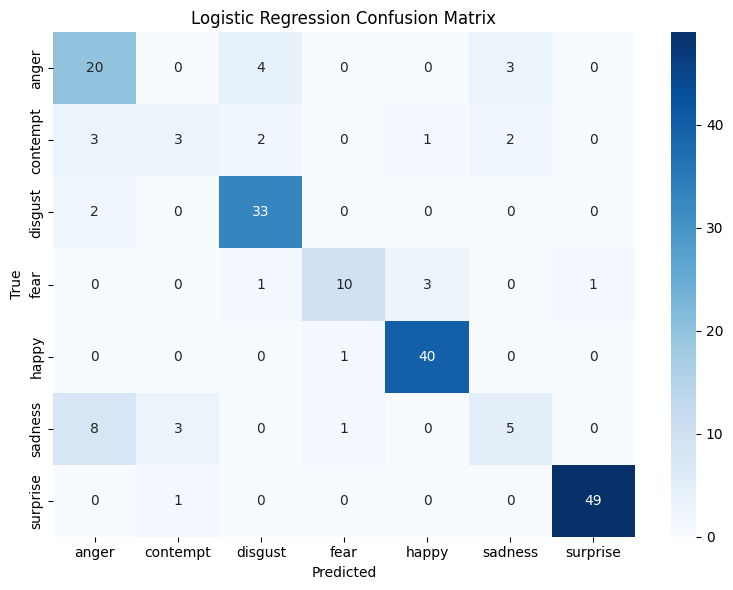

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Load the dataset ---
df = pd.read_csv("processed_faces_newFinal5/valence_arousal_vectors_normalized.csv")

# --- Encode emotion labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Select Features & Target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]
y = df['emotion_encoded']

# --- Split into train and test sets ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Train Logistic Regression ---
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

# --- Predict ---
y_train_pred = log_model.predict(X_train)
y_test_pred = log_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy (Logistic Regression): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (Logistic Regression): {test_acc * 100:.2f}%")


# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()



✅ Training Accuracy (KNN): 93.11%
✅ Testing Accuracy  (KNN): 83.16%

Classification Report:
              precision    recall  f1-score   support

       anger       0.65      0.74      0.69        27
    contempt       0.62      0.45      0.53        11
     disgust       0.80      0.94      0.87        35
        fear       0.79      0.73      0.76        15
       happy       0.93      0.95      0.94        41
     sadness       0.58      0.41      0.48        17
    surprise       1.00      0.96      0.98        50

    accuracy                           0.83       196
   macro avg       0.77      0.74      0.75       196
weighted avg       0.83      0.83      0.83       196



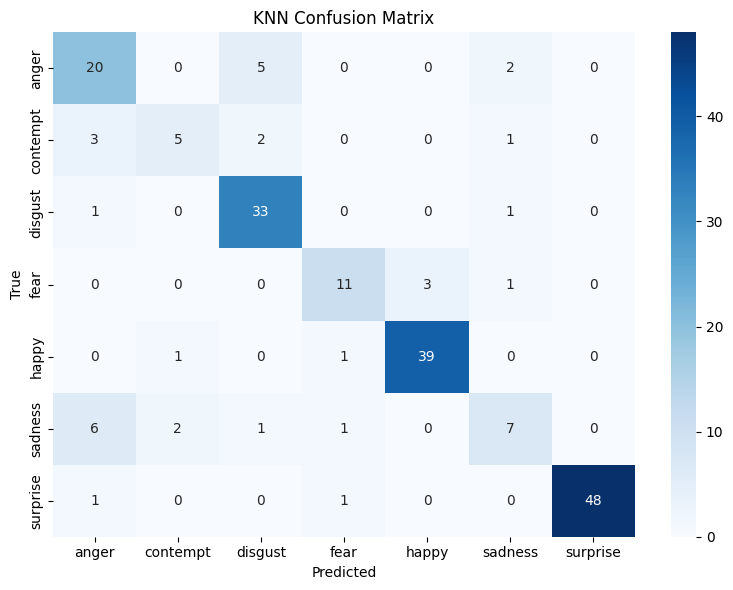

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load the dataset ---
df = pd.read_csv("processed_faces_newFinal5/valence_arousal_vectors_normalized.csv")

# --- Encode emotion labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Select Features & Target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]]
y = df['emotion_encoded']

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- Train KNN model ---
knn_model = KNeighborsClassifier(n_neighbors=5)  # You can tune k later
knn_model.fit(X_train, y_train)

# --- Predict ---
y_train_pred = knn_model.predict(X_train)
y_test_pred = knn_model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n✅ Training Accuracy (KNN): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (KNN): {test_acc * 100:.2f}%")


# --- Classification Report ---
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

# --- Confusion Matrix ---
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title("KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


Epoch 1/50
45/45 [==============================] - 0s 3ms/step - loss: 1.8287 - accuracy: 0.3106 - val_loss: 1.6560 - val_accuracy: 0.4684
Epoch 2/50
45/45 [==============================] - 0s 1ms/step - loss: 1.4609 - accuracy: 0.5291 - val_loss: 1.2964 - val_accuracy: 0.5063
Epoch 3/50
45/45 [==============================] - 0s 1ms/step - loss: 1.1594 - accuracy: 0.6312 - val_loss: 1.0820 - val_accuracy: 0.5949
Epoch 4/50
45/45 [==============================] - 0s 1ms/step - loss: 1.0115 - accuracy: 0.6695 - val_loss: 0.9430 - val_accuracy: 0.6709
Epoch 5/50
45/45 [==============================] - 0s 1ms/step - loss: 0.9117 - accuracy: 0.6936 - val_loss: 0.8367 - val_accuracy: 0.6709
Epoch 6/50
45/45 [==============================] - 0s 1ms/step - loss: 0.8222 - accuracy: 0.7021 - val_loss: 0.7612 - val_accuracy: 0.6709
Epoch 7/50
45/45 [==============================] - 0s 1ms/step - loss: 0.7831 - accuracy: 0.7163 - val_loss: 0.6916 - val_accuracy: 0.6962
Epoch 8/50
45/45 [==

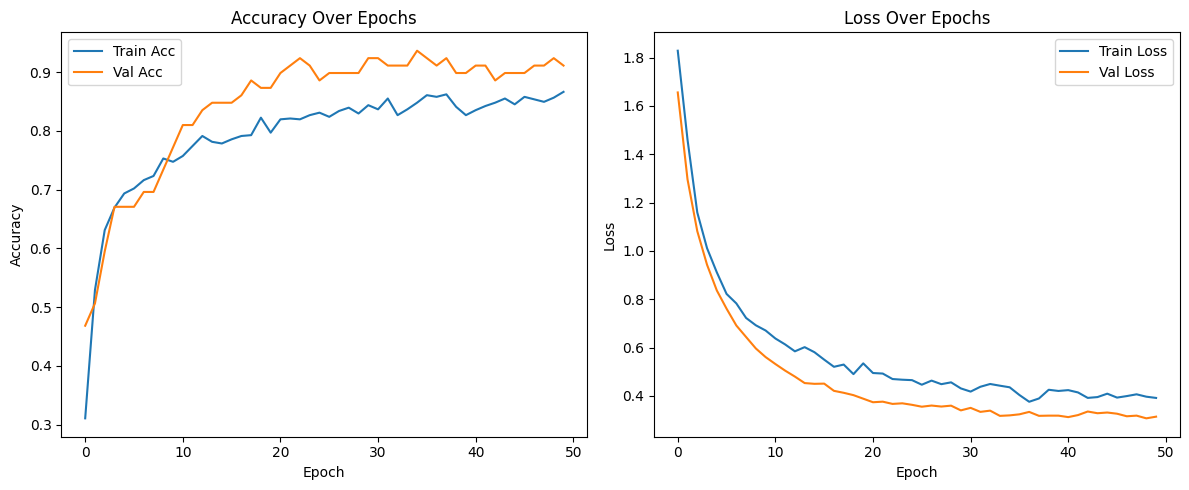

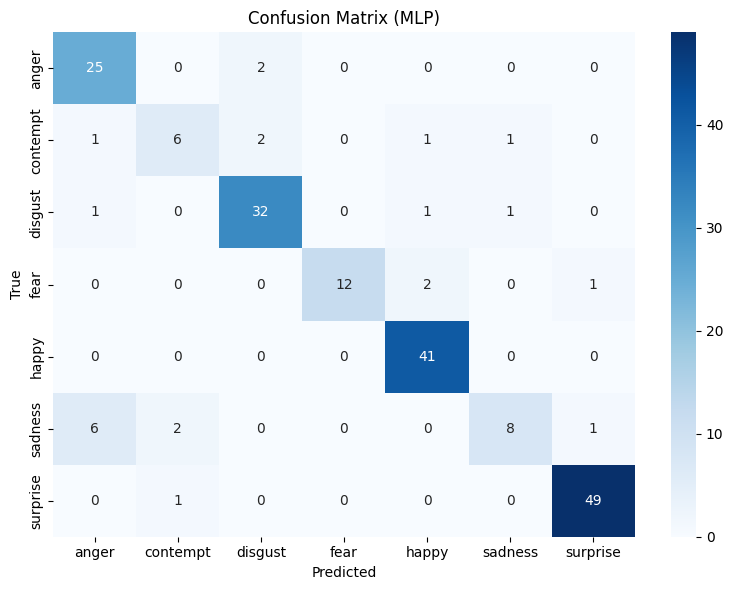

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# --- Load Dataset ---
df = pd.read_csv("processed_faces_newFinal5/valence_arousal_vectors_normalized.csv")

# --- Encode Labels ---
label_encoder = LabelEncoder()
df['emotion_encoded'] = label_encoder.fit_transform(df['emotion'])

# --- Feature & Target ---
X = df[[col for col in df.columns if '_valence' in col or '_arousal' in col]].values
y = to_categorical(df['emotion_encoded'])

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=df['emotion_encoded'], random_state=42
)

# --- MLP Model ---
model = Sequential([
    Dense(64, activation='relu', input_shape=(12,)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(y.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# --- Train the Model ---
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# --- Evaluate ---
train_loss, train_acc = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

# print(f"\n✅ Training Accuracy (MLP): {train_acc:.2f}")
# print(f"✅ Testing Accuracy (MLP): {test_acc:.2f}")

print(f"\n✅ Training Accuracy (MLP): {train_acc * 100:.2f}%")
print(f"✅ Testing Accuracy  (MLP): {test_acc * 100:.2f}%")


# --- Predictions ---
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# --- Classification Report ---
print("\n✅ Classification Report:")
print(classification_report(y_test_labels, y_pred_labels, target_names=label_encoder.classes_))

# --- Plot Accuracy & Loss Curves ---
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Decode test labels ---
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_labels, y_pred_labels)
class_names = label_encoder.classes_

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (MLP)')
plt.tight_layout()
plt.show()

